<a href="https://colab.research.google.com/github/katek28/Deep-Learning-projects/blob/main/Masters_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Master's project: Exploring and comparing data selection methods in the pre-processing step of a deep learning framework for automatic tumor segmentation on PET-CT images





---


**Abstract:** Automatic segmentation of primary tumors in oropharyngeal cancer patients using PET/CT images and deep learning has the potential to improve
radiation oncology workflows. However, 2D tumor segmentation using deep
learning is a data imbalance problem and a method of PET and CT slice
selection affects the convergence of the deep learning model. The aim of the
current project was to find a way to select sequences to improve the
performance of the existed deep learning segmentation model. To select the
'right amount' of sequences without tumor in an unsupervised manner,
clustering methods were explored. The trained clustering algorithms were
used to group the training and validation data of the existed segmentation model into clusters. The performance of the proposed method was assessed
using the segmentation model. The promising results of the proposed data
selection method were confirmed by improved metrics of the segmentation
model (mean Dice Score Coefficient, precision and recall).




*   Since it is currently developing project, I have no rights to share the entire code. Here there is the part of the code for negative sequences selection.






In [ ]:
!pip install monai==0.7.0 --user
!pip install "git+https://github.com/ProjectMONAI/MONAI#egg=monai[nibabel,ignite,tqdm]" --user
!pip install matplotlib --user
!pip install --user scikit-learn
!pip install --user seaborn
!pip install --user fuzzy-c-means
import glob
import argparse
import random
import os
import random
import json
import sys
sys.dont_write_bytecode = True
import random
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import cm
import tempfile
import nibabel as nib
import SimpleITK as sitk
import numpy as np
import pandas as pd
from scipy.stats import kurtosis
from scipy.stats import skew
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import monai
from monai.config import print_config
from monai.utils import first
from monai.config import KeysCollection
from monai.data import Dataset, ArrayDataset, create_test_image_3d,
DataLoader, CacheDataset
from monai.transforms import (
Transform,
MapTransform,58
Randomizable,
AddChannel,
AddChanneld,
Compose,
LoadImage,
LoadImaged,
Lambda,
Lambdad,
RandSpatialCrop,
RandSpatialCropd,
ThresholdIntensityd,
NormalizeIntensityd,
ScaleIntensityd,
ConcatItemsd,
RandFlipd,
ToTensor,
ToTensord,
Orientation,
Rotate,
Resize,
CenterSpatialCrop,
)
print_config()


In [ ]:
    
    def __init__(self, keys, spatial_size=(144,144,144)):
        
        super().__init__(keys)
        self.spatial_size = spatial_size
        self.resizer = CenterSpatialCrop(self.spatial_size)
        
    def resize(self, img):
        
        if np.shape(img)!=self.spatial_size:
            return img[:144,:144,:144] #self.resizer(img) 
        else:
            return img
             

    def __call__(self, dictionary):
        
        dictionary = dict(dictionary)
        
        for key in self.keys:
            dictionary[key] = self.resize(dictionary[key]) 
        
        return dictionary
        
def dataset_prep(lists):
    dataset_train=[]
    for lista in lists:
        dataset_train.append(
        {'ct':lista[1],
        'pet':lista[2],
        'gtv':lista[3],
        'slice':lista[4],
        'ID':lista[0] 
    })
    return dataset_train
        
class Create_sequences(MapTransform):
    
    def __init__(self, keys, seq = 3, plane = "x"):
        
        super().__init__(keys)
        self.sequences = seq
        self.plane=plane
        #self.modality=modality
        
    def slicing(self, img, starting):
        
        indx=starting
        sequence=[]
        
        for i in range(indx, indx+self.sequences):
            
            if self.plane=="x":
                ima = np.rot90(img[:,:,i],3)
            elif self.plane=="y":
                ima = np.rot90(img[:,i,:])
            elif self.plane=="z":
                ima = np.rot90(img[i,:,:])
            
            sequence.append(ima)
        
        return np.hstack(sequence)    

    def __call__(self, dictionary):
        
        dictionary = dict(dictionary)
        starting = dictionary["slice"]
        
        for key in self.keys:
            dictionary[key] = self.slicing(dictionary[key],starting) #self.create_sequence.
        
        return dictionary
        
def initialize_transform(images_keys, plane_, ct_norm="z_norm", pet_norm="z_norm", test=False):
    
    normalize_ct={
        "z_norm": NormalizeIntensityd(("ct"), subtrahend=None, divisor=None, nonzero=False, channel_wise=False, allow_missing_keys=False),
        "min_max_norm": NormalizeIntensityd(("ct"), subtrahend=None, divisor=None, nonzero=False, channel_wise=False, allow_missing_keys=False)
    }
    normalize_pet={
        "z_norm": NormalizeIntensityd(("pet"), subtrahend=None, divisor=None, nonzero=False, channel_wise=False, allow_missing_keys=False),
        "min_max_norm": NormalizeIntensityd(("pet"), subtrahend=None, divisor=None, nonzero=False, channel_wise=False, allow_missing_keys=False)
    }
    
    load_seq=[
        LoadImaged(keys=images_keys),
        Resized_mine(keys=images_keys, spatial_size=(144,144,144)),
    ]
    
    #if test==False:
        #load_seq.append(RandFlipd(keys=images_keys, prob=0.5, spatial_axis=2))
    
    pre_processing_ct=[
        ThresholdIntensityd(("ct"), threshold=-1024, above=True, cval=-1024, allow_missing_keys=False),
        ThresholdIntensityd(("ct"), threshold=1024, above=False, cval=1024, allow_missing_keys=False),
    ]

    pre_processing_pet=[
        ThresholdIntensityd(("pet"), threshold=0, above=True, cval=0.0, allow_missing_keys=False)
    ]
    
    try:
        pre_processing_ct.append(normalize_ct[ct_norm])
    except KeyError:
        "CT normalization technique not available!"
        
    try:
        pre_processing_pet.append(normalize_pet[pet_norm])
    except KeyError:
        "PET normalization technique not available!"
        
    sequence_prep=[
        Create_sequences(keys=images_keys, plane=plane_),
        AddChanneld(keys=images_keys), 
        ConcatItemsd(keys=["ct","pet"], name="input"),
        ToTensord(keys=["input", "gtv"])
    ]
    
    train_tranforms = Compose(load_seq+pre_processing_ct+sequence_prep) #pre_processing_pet
    
    return train_tranforms

def initialize_transform_norm(images_keys, plane_, ct_norm="z_norm", pet_norm="min_max_norm", test=False):
    
    
    normalize_pet={
        "z_norm": NormalizeIntensityd(("pet"), subtrahend=None, divisor=None, nonzero=False, channel_wise=False, allow_missing_keys=False),
        "min_max_norm": ScaleIntensityd(("pet"), minv=0.0, maxv=1.0, allow_missing_keys=False)
    }
    
    load_seq=[
        LoadImaged(keys=images_keys),
        Resized_mine(keys=images_keys, spatial_size=(144,144,144)),
    ]
    
    #if test==False:
        #load_seq.append(RandFlipd(keys=images_keys, prob=0.5, spatial_axis=2))
    
    pre_processing_ct=[
        ThresholdIntensityd(("ct"), threshold=-1024, above=True, cval=-1024, allow_missing_keys=False),
        ThresholdIntensityd(("ct"), threshold=1024, above=False, cval=1024, allow_missing_keys=False),
    ]

    pre_processing_pet=[
        ThresholdIntensityd(("pet"), threshold=0, above=True, cval=0.0, allow_missing_keys=False)
    ]
    
   # try:
       # pre_processing_ct.append(normalize_ct[ct_norm])
   # except KeyError:
      #  "CT normalization technique not available!"
        
    try:
        print('Normalization added')
        pre_processing_pet.append(normalize_pet[pet_norm])
    except KeyError:
        "PET normalization technique not available!"
        
    sequence_prep=[
        Create_sequences(keys=images_keys, plane=plane_),
        AddChanneld(keys=images_keys), 
        ConcatItemsd(keys=["ct","pet"], name="input"),
        ToTensord(keys=["input", "gtv"])
    ]
    
    train_tranforms = Compose(load_seq+pre_processing_pet+sequence_prep) #pre_processing_pet
    
    return train_tranforms


In [ ]:
def read_split_file(path):

    with open(path, 'r') as inf:
        dict_from_file = eval(inf.read())
        
    return dict_from_file

#### Main

split_data = read_split_file('/data/s4880641/model_test/1/image_split_new.json')
random.seed(100)

train_list = dataset_prep(split_data['training'])
validate_list = dataset_prep(split_data['validate'])
         
image_keys=('ct', 'pet', 'gtv')

train_tranforms_m = initialize_transform(image_keys, 'x', ct_norm="z_norm", pet_norm="z_norm", test=False)

train_ds_m = Dataset(data=train_list, transform=train_tranforms_m)
train_loader_m = DataLoader(train_ds_m, batch_size=1, shuffle=True, num_workers=0, pin_memory=True)
im_train_m=(train_ds[5]["pet"])
im_train_id =(train_ds[5]["ID"])
im_train_slice =(train_ds[5]["slice"])

%matplotlib inline
plt.imshow(im_train[0])


def plot_hist(pet, name):
    
    plt.hist(pet, bins=15)
    plt.show()
    #plt.savefig('/data/s4880641/histogram/'+name+'_hist.png')
    
def entropy(signal):
        '''
        function returns entropy of a signal
        signal must be a 1-D numpy array
        '''
        lensig=signal.size
        symset=list(set(signal))
        numsym=len(symset)
        propab=[np.size(signal[signal==i])/(1.0*lensig) for i in symset]
        ent=np.sum([p*np.log2(1.0/p) for p in propab])
        return ent

def en(im_arr):
    #im_arr = im_train[0]
    im = Image.fromarray(np.uint8(cm.plasma(im_arr)*255)) #entropy
    #plt.imshow(im)
    greyIm=im.convert('L')
    greyIm = np.array(greyIm)

    N=5
    S=greyIm.shape
    E=np.array(greyIm)
    for row in range(S[0]):
            for col in range(S[1]):
                    Lx=np.max([0,col-N])
                    Ux=np.min([S[1],col+N])
                    Ly=np.max([0,row-N])
                    Uy=np.min([S[0],row+N])
                    region=greyIm[Ly:Uy,Lx:Ux].flatten()
                    E[row,col]=entropy(region)
    return np.mean(E)

im_arr = im_train[0]
im = Image.fromarray(np.uint8(cm.plasma(im_arr)*255)) #entropy
#plt.imshow(im)
greyIm=im.convert('L')
greyIm = np.array(greyIm)

N=5
S=greyIm.shape
E=np.array(greyIm)
for row in range(S[0]):
        for col in range(S[1]):
                Lx=np.max([0,col-N])
                Ux=np.min([S[1],col+N])
                Ly=np.max([0,row-N])
                Uy=np.min([S[0],row+N])
                region=greyIm[Ly:Uy,Lx:Ux].flatten()
                E[row,col]=entropy(region)

%matplotlib inline                
plt.figure(figsize=(20,10))                
plt.subplot(1,3,1)
plt.imshow(im)

plt.subplot(1,3,2)
plt.imshow(greyIm, cmap=plt.cm.gray)

plt.subplot(1,3,3)
plt.imshow(E, cmap=plt.cm.jet)
plt.xlabel('Entropy') # in 10x10 neighbourhood

plt.colorbar(fraction=0.046, pad=0.08)

plt.show()


In [ ]:
##Creating Dataframe with extracted features

i=0
df = pd.DataFrame(columns = ["ID", "slice", "meanSUV", "maxSUV", "minSUV", "std", "skewness", "kurtosis", "entropy"])

for image in train_ds_m:
    #i=i+1
    pet = image["pet"][0]   
    id_ = image["ID"]
    slice_ = image["slice"]
    maxv = np.max(pet)
    mean = np.mean(pet)
    
    minv = np.min(pet)
    std = np.std(pet)
    sk = np.mean(skew(pet))
    kurt = np.mean(kurtosis(pet))
    entropy_mean = en(pet)
    
    df= df.append({'ID': id_, 'slice': slice_, 'maxSUV': maxv, 'minSUV': minv, 'meanSUV': mean, 'std': std, 'skewness': sk, 'kurtosis':kurt, 'entropy':entropy_mean}, ignore_index=True)     

df.to_csv('/data/s4880641/dataframe/table_f.csv', index = False, header=True)

#Data representation

df = pd.read_csv('/data/s4880641/dataframe/table_final.csv')
df_analysis=df.drop(['ID','slice'], axis=1)
df_analysis.to_csv('/data/s4880641/dataframe/table_work.csv', index = False, header=True)
df_analysis

# Visualizing the correlation of the data and identifying variables for further analysis
g = sns.PairGrid(df_analysis, hue = "tumor_no tumor")
g.map(sns.scatterplot)
g.add_legend()

#K-Means clustering

df_fin=df_analysis.dropna()
data =df_fin[~df_fin.isin([np.nan, np.inf, -np.inf]).any(1)]
data.to_csv('/data/s4880641/dataframe/data.csv', index = False, header=True)

X = pd.DataFrame(data).to_numpy()

# Determine optimal cluster number with elbow method
wcss = []

for i in range(1, 11):
    model = KMeans(n_clusters = i,     
                    init = 'k-means++', 
                    max_iter = 300,  
                    n_init = 10,  
                    random_state = 0)   
    model.fit(data)                              
    wcss.append(model.inertia_)
    
# Show Elbow plot
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')                                
plt.xlabel('Number of clusters')                        
plt.ylabel('Within Cluster Sum of Squares (WCSS)')      

boolMarker = data["tumor_no tumor"].to_numpy()

#Model for k-means clustering predicting
kmeans = KMeans(n_clusters=3, init="k-means++", max_iter=50000, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(data)

#Visualization of K-means clustering using two features

def split(arr,colorArr,cond):
    return [arr[cond], arr[~cond], colorArr[cond], colorArr[~cond]]

[data1, data2, color1, color2] = split(X,kmeans.labels_,boolMarker==1)
%matplotlib inline
plt.scatter(data1[:,1],data1[:,6],c=color1, marker="+", alpha=0.4)
plt.scatter(data2[:,1],data2[:,6],c=color2,marker="d", alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:,1],kmeans.cluster_centers_[:,6],s=100,c='red',marker="+")
plt.title("K means clustering") #title
plt.xlabel("Maximum SUV") #x label
plt.ylabel("entropy") #y label
plt.legend(["Tumor" , "NoTumor"], loc= 'upper right')
plt.show()

kmeans.cluster_centers_[:,0]
kmeans.cluster_centers_[:,1]
kmeans.inertia_
sns.countplot(pred_y)

#FUZZY C MEANS CLUSTERING

from fcmeans import FCM

fcm = FCM(n_clusters=3)
fcm.fit(X)

# outputs
fcm_centers = fcm.centers
fcm_labels = fcm.predict(X)

# plot result
boolMarker = data["tumor_no tumor"].to_numpy()

def split(arr,colorArr,cond):
    return [arr[cond], arr[~cond], colorArr[cond], colorArr[~cond]]

[data1, data2, color1, color2] = split(X,fcm_labels,boolMarker==1)
%matplotlib inline
plt.scatter(data1[:,0],data1[:,1],c=color1, marker="+", alpha=0.4)
plt.scatter(data2[:,0],data2[:,1],c=color2,marker="d", alpha=0.7)
plt.scatter(fcm_centers[:,0],fcm_centers[:,1],s=100,c='red',marker="+")
plt.title("Fuzzy-c means means clustering") #title
plt.xlabel("clusters") #x label
plt.ylabel("Maximum SUV") #y label
plt.legend(["Tumor" , "NoTumor"], loc= 'upper right')
plt.show()




In [ ]:
import random
random.seed(100)

dfa = pd.read_csv('/data/s4880641/split/training_data.csv')
dfa=dfa.dropna()
data = pd.read_csv('/data/s4880641/dataframe/data.csv')


X = pd.DataFrame(data).to_numpy()
Y=whiten(X)
model = KMeans(n_clusters=3, init="k-means++", max_iter=50000, n_init=10, random_state=0)
model.fit(Y)

dat=dfa.drop(['ID','slice'], axis=1)

y=whiten(dat)
pred_y = model.fit_predict(y)

model.labels_
dfa['cluster']=model.labels_
dfa.to_csv('/data/s4880641/dataframe/table_clust.csv', index = False, header=True)

dfc = pd.read_csv('/data/s4880641/dataframe/table_clust3.csv')

%matplotlib inline
sns.countplot(pred_y)

#Identifying amount of tumor/no tumor sequences in the dataset and calculating 20% of the dataset
dfa['tumor'].value_counts()
n= 1561/4

#Clusters are assigned to the data

df1_tumor=dfc[dfc['tumor']==1]
df1_notumor=dfc[dfc['tumor']==0]

df0 = df1_notumor[df1_notumor['cluster']==0]
df1 = df1_notumor[df1_notumor['cluster']==1]
df2 = df1_notumor[df1_notumor['cluster']==2]

#Selecting equal amount of sequences from each cluster within 20%

d0 = df0.sample(n=130)
d1 = df1.sample(n=130)
d2 = df2.sample(n=130)

#Final training dataframe
pieces=[df1_tumor,d0,d1,d2]
result = pd.concat(pieces)
result=result.drop(['meanSUV','maxSUV','minSUV','std', 'skewness','kurtosis','entropy','tumor','cluster' ], axis=1)
result.to_csv('/data/s4880641/dataframe/table_training_all.csv', index = False, header=True)
result

dfa = pd.read_csv('/data/s4880641/split/validate_data.csv')
dfa=dfa.dropna()
data = pd.read_csv('/data/s4880641/dataframe/data.csv')

import random
random.seed(100)

X = pd.DataFrame(data).to_numpy()
Y=whiten(X)
model = KMeans(n_clusters=3, init="k-means++", max_iter=50000, n_init=10, random_state=0)
model.fit(Y)

dat=dfa.drop(['ID','slice'], axis=1)

y=whiten(dat)
pred_y = model.fit_predict(y)

model.labels_
dfa['cluster']=model.labels_
dfa.to_csv('/data/s4880641/dataframe/table_clust.csv', index = False, header=True)

dfc = pd.read_csv('/data/s4880641/dataframe/table_clust3.csv')

%matplotlib inline
sns.countplot(pred_y)

#Identifying amount of tumor/no tumor sequences in the dataset and calculating 20% of the dataset
dfa['tumor'].value_counts()
n= 702/4

#Clusters are assigned to the data

df1_tumor=dfc[dfc['tumor']==1]
df1_notumor=dfc[dfc['tumor']==0]

df0 = df1_notumor[df1_notumor['cluster']==0]
df1 = df1_notumor[df1_notumor['cluster']==1]
df2 = df1_notumor[df1_notumor['cluster']==2]

#Selecting equal amount of sequences from each cluster within 20%

d0 = df0.sample(n=59)
d1 = df1.sample(n=58)
d2 = df2.sample(n=59)

#Final training dataframe
pieces=[df1_tumor,d0,d1,d2]
result = pd.concat(pieces)
result=result.drop(['meanSUV','maxSUV','minSUV','std', 'skewness','kurtosis','entropy','tumor','cluster' ], axis=1)
result.to_csv('/data/s4880641/dataframe/table_validate_all.csv', index = False, header=True)
result


**Method evaluation**

After the new training and validation dataset were created as explained in the previous section, the model was trained and evaluated to assess the performance of the method proposed in the study. All models were trained on sequences extracted from 124 patients and validated on 31 patients. Model 1 was used as benchmark. The data split was created selecting all sequences containing a percentage of tumor above 2.5%  (representing the 80% of the entire dataset), a small percentage of sequences with tumor below 2.5% (15% of the entire dataset), a small percentage of sequences containing no tumor (5%).
Training and validation loss functions for all models trained are reported below. From these images it is possible to say that the created models are more instable during training, most of the models have spikes during the entire training process. The validation loss function decreases for all newly created models. Most of the models have spikes in the validation loss function as well. In some models spikes become smaller with the time.



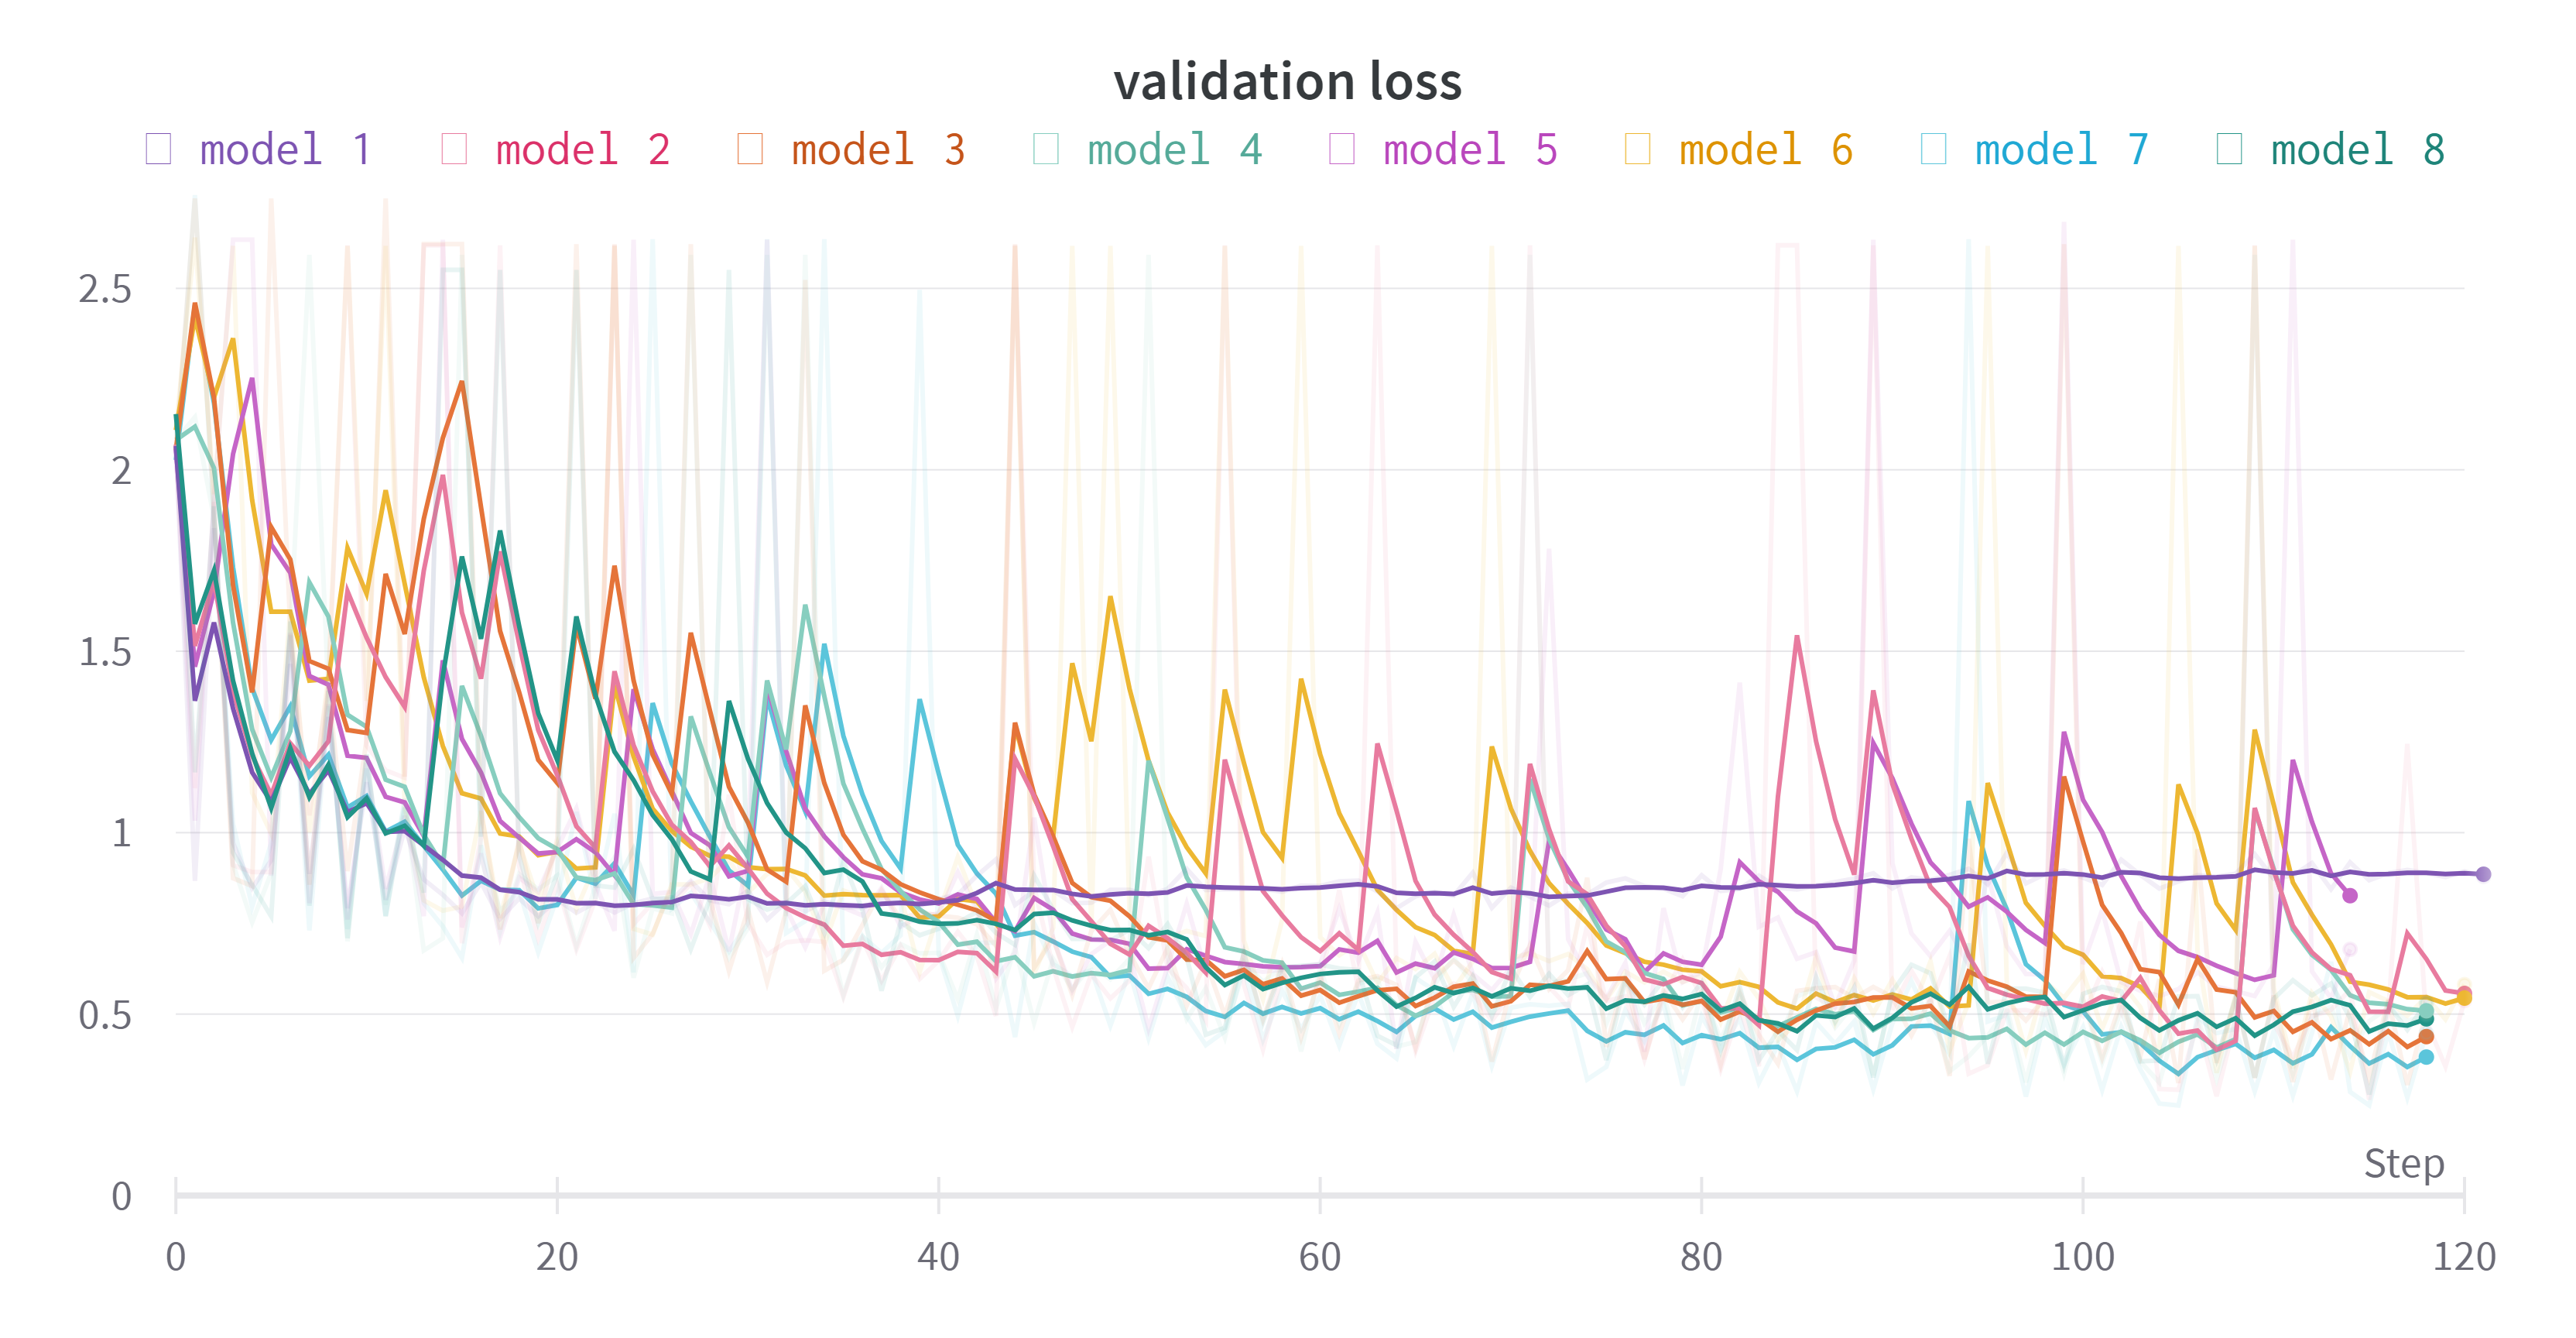

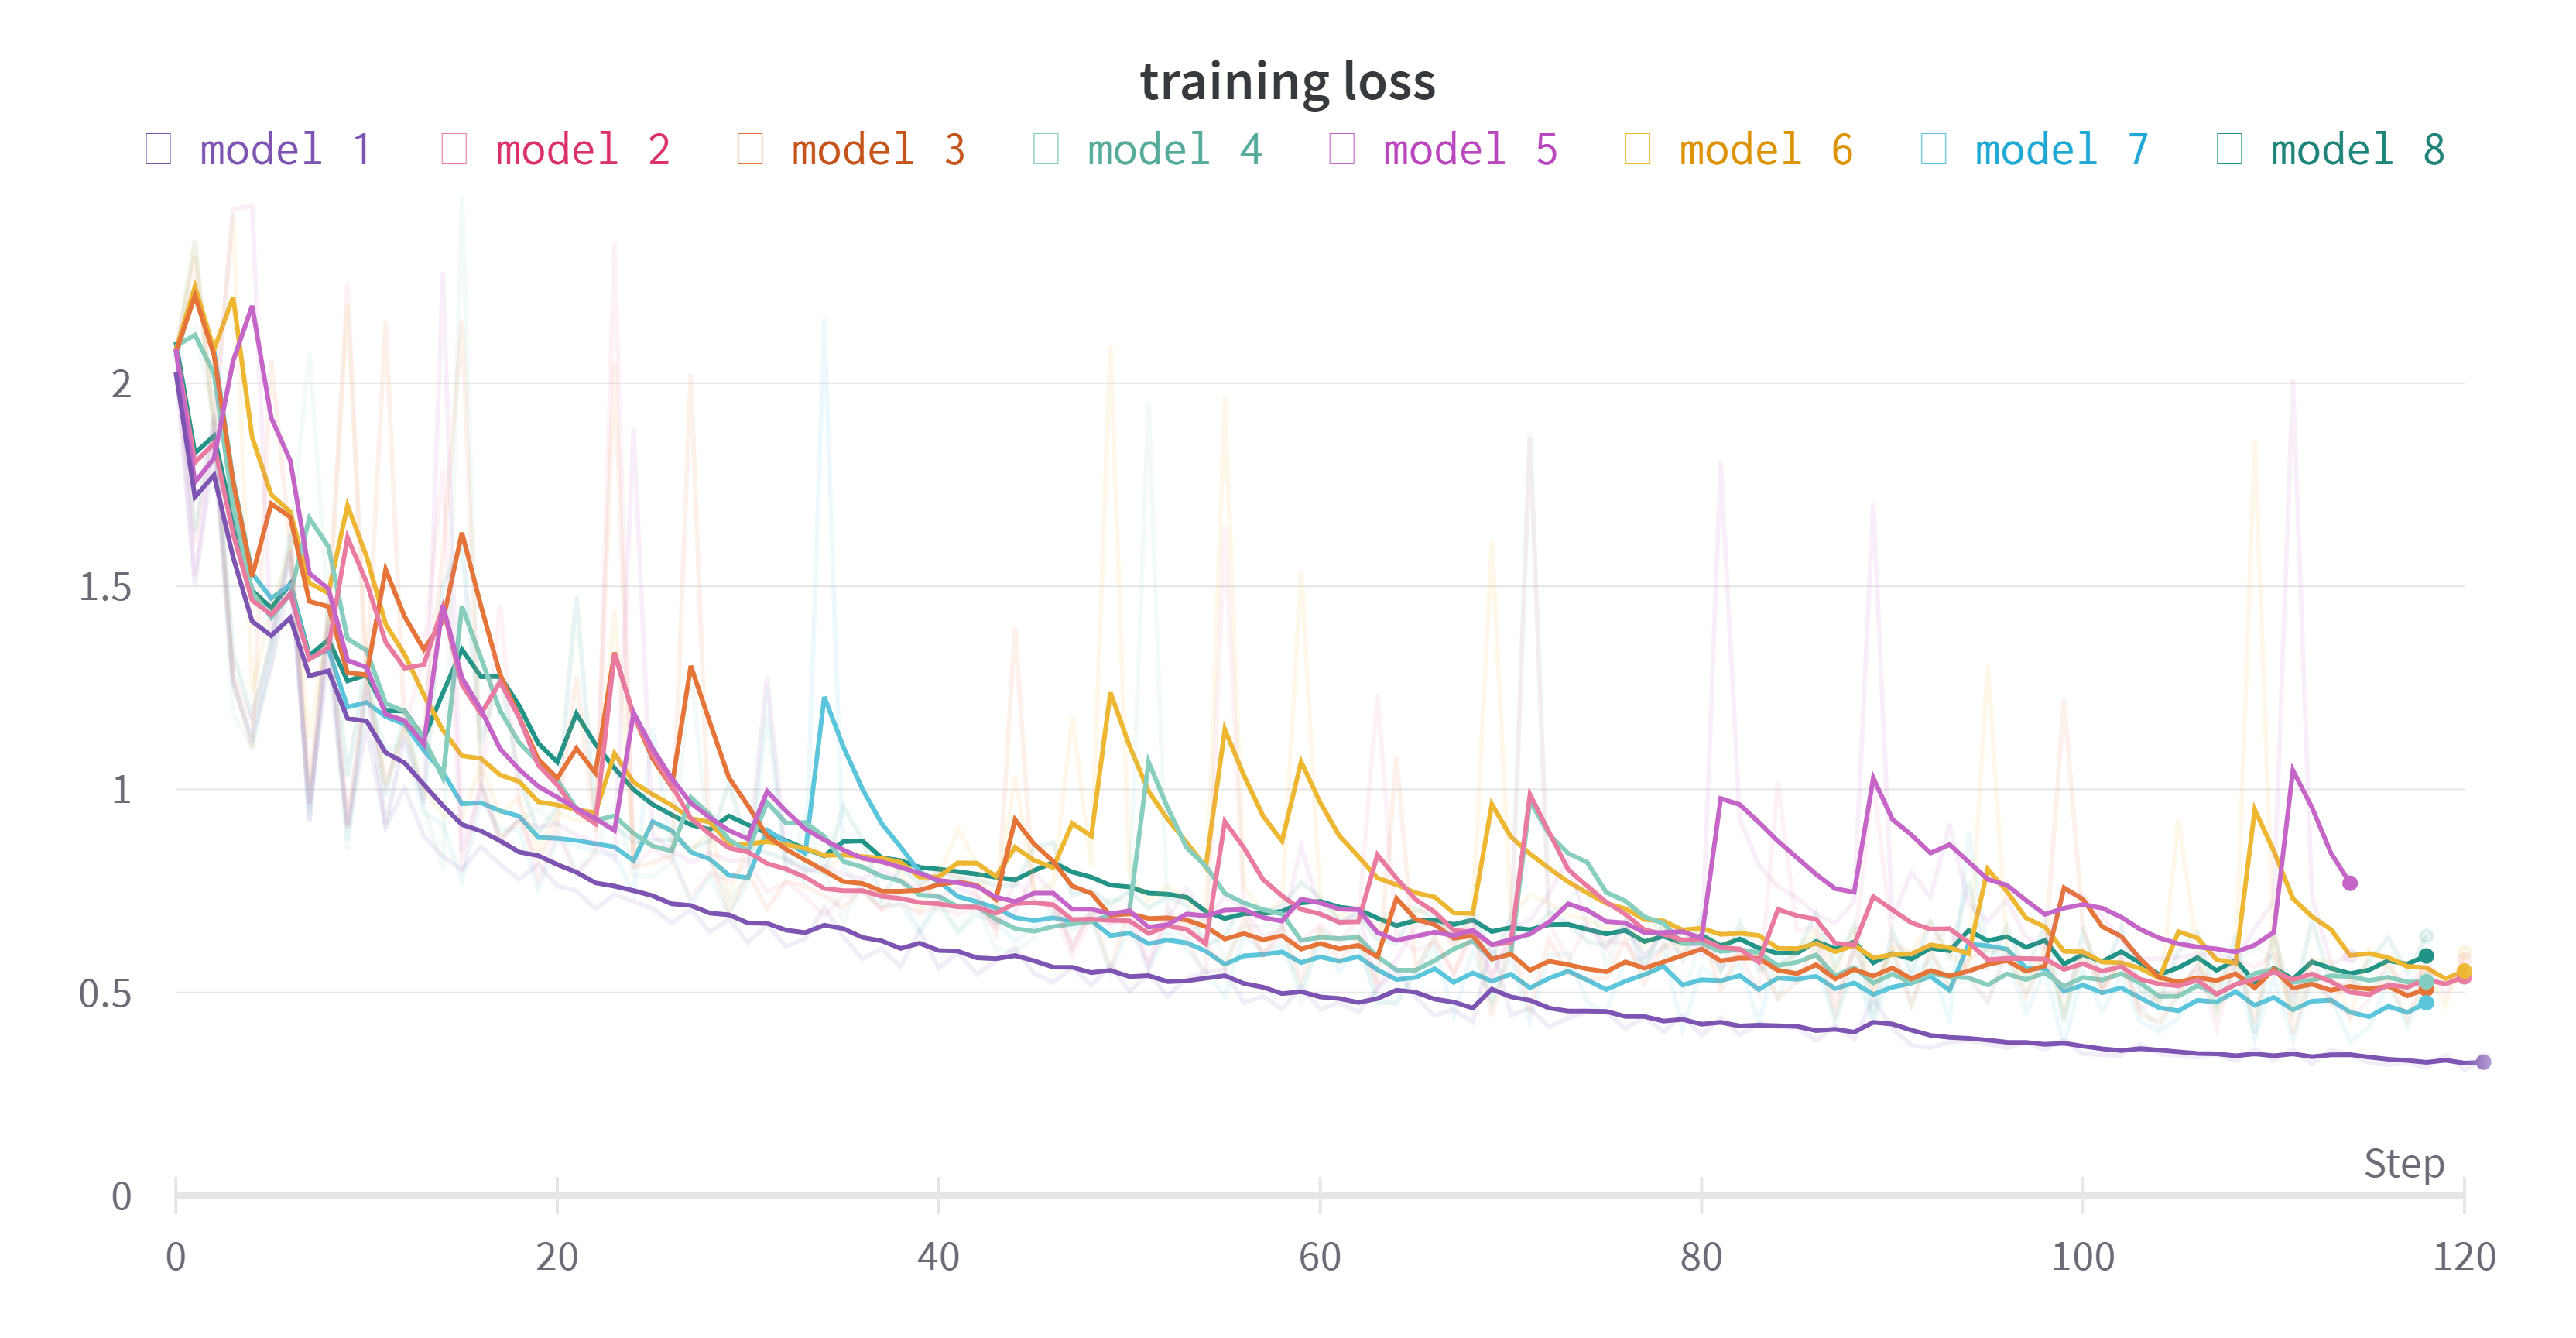

During training on sequences precision, recall and mean dice coefficient are calculated on the validation set made of selected sequences (see Figures 22-24). The different models were trained for a maximum of 150 epochs. The selected checkpoint was the one corresponding to the lowest value of validation loss after 100 epochs. Lastly, the selected checkpoint of each model was used to create predictions on all sequences contained in the 144x144x144 pixels volumes. Reconstructed predicted volumes were evaluated using precision, recall and mean dice score coefficient (DSC) at different probability thresholds.



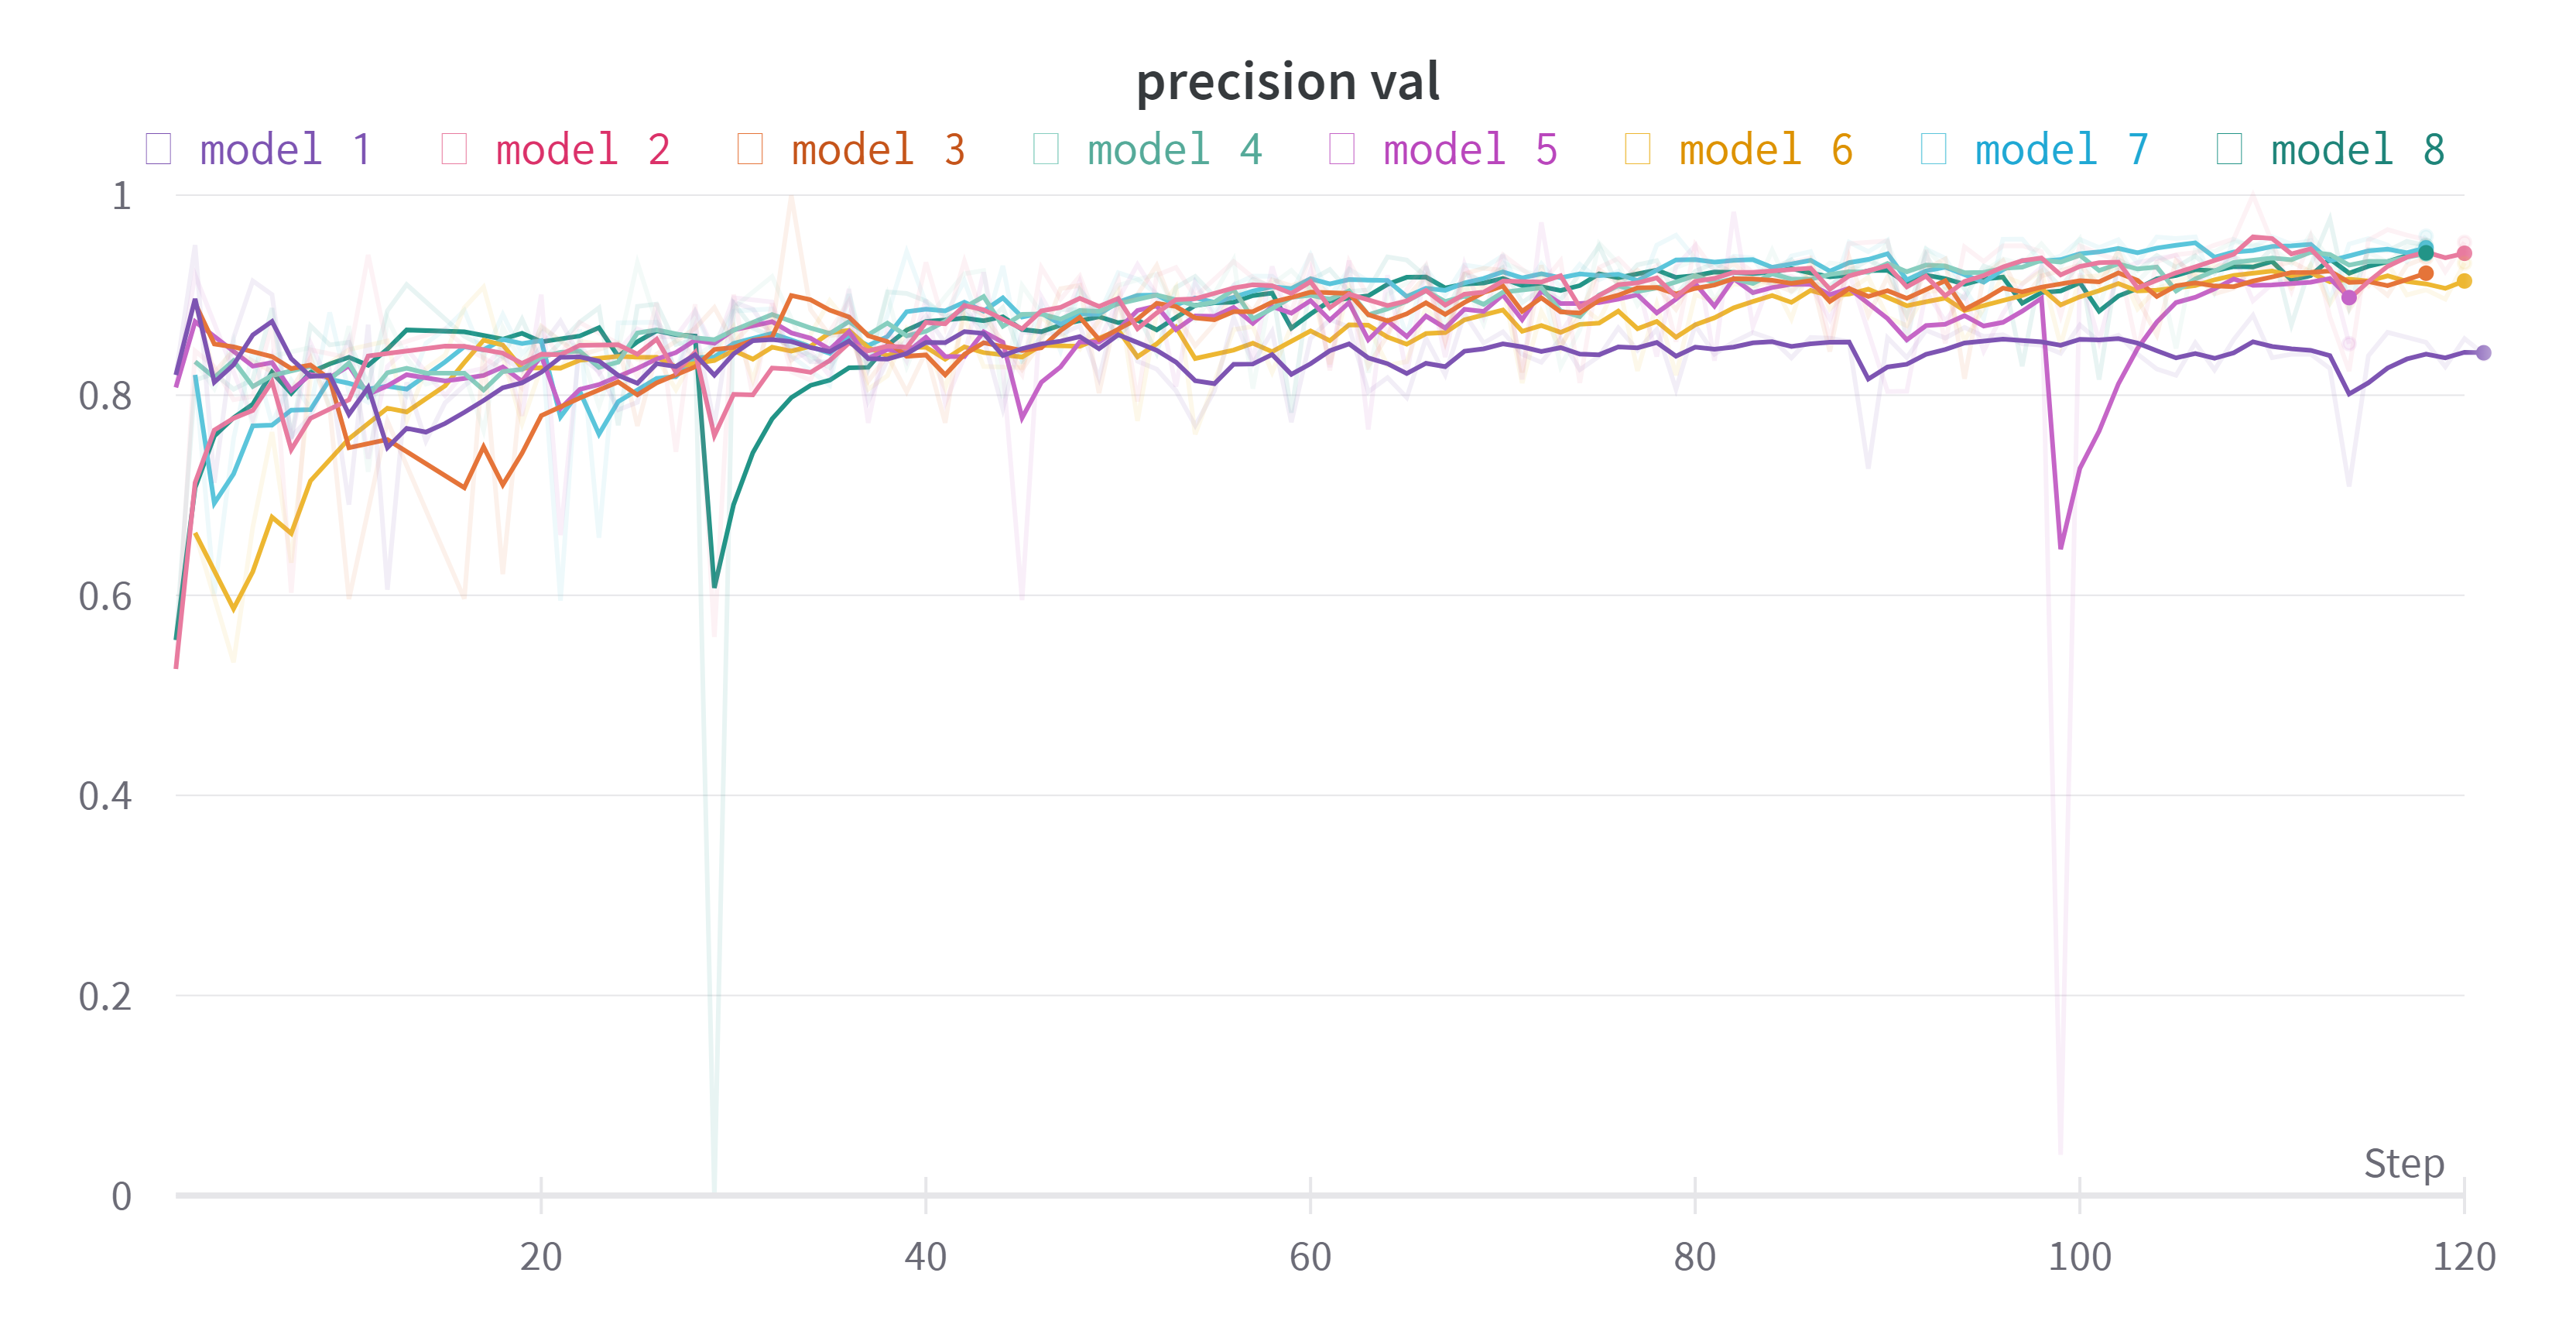

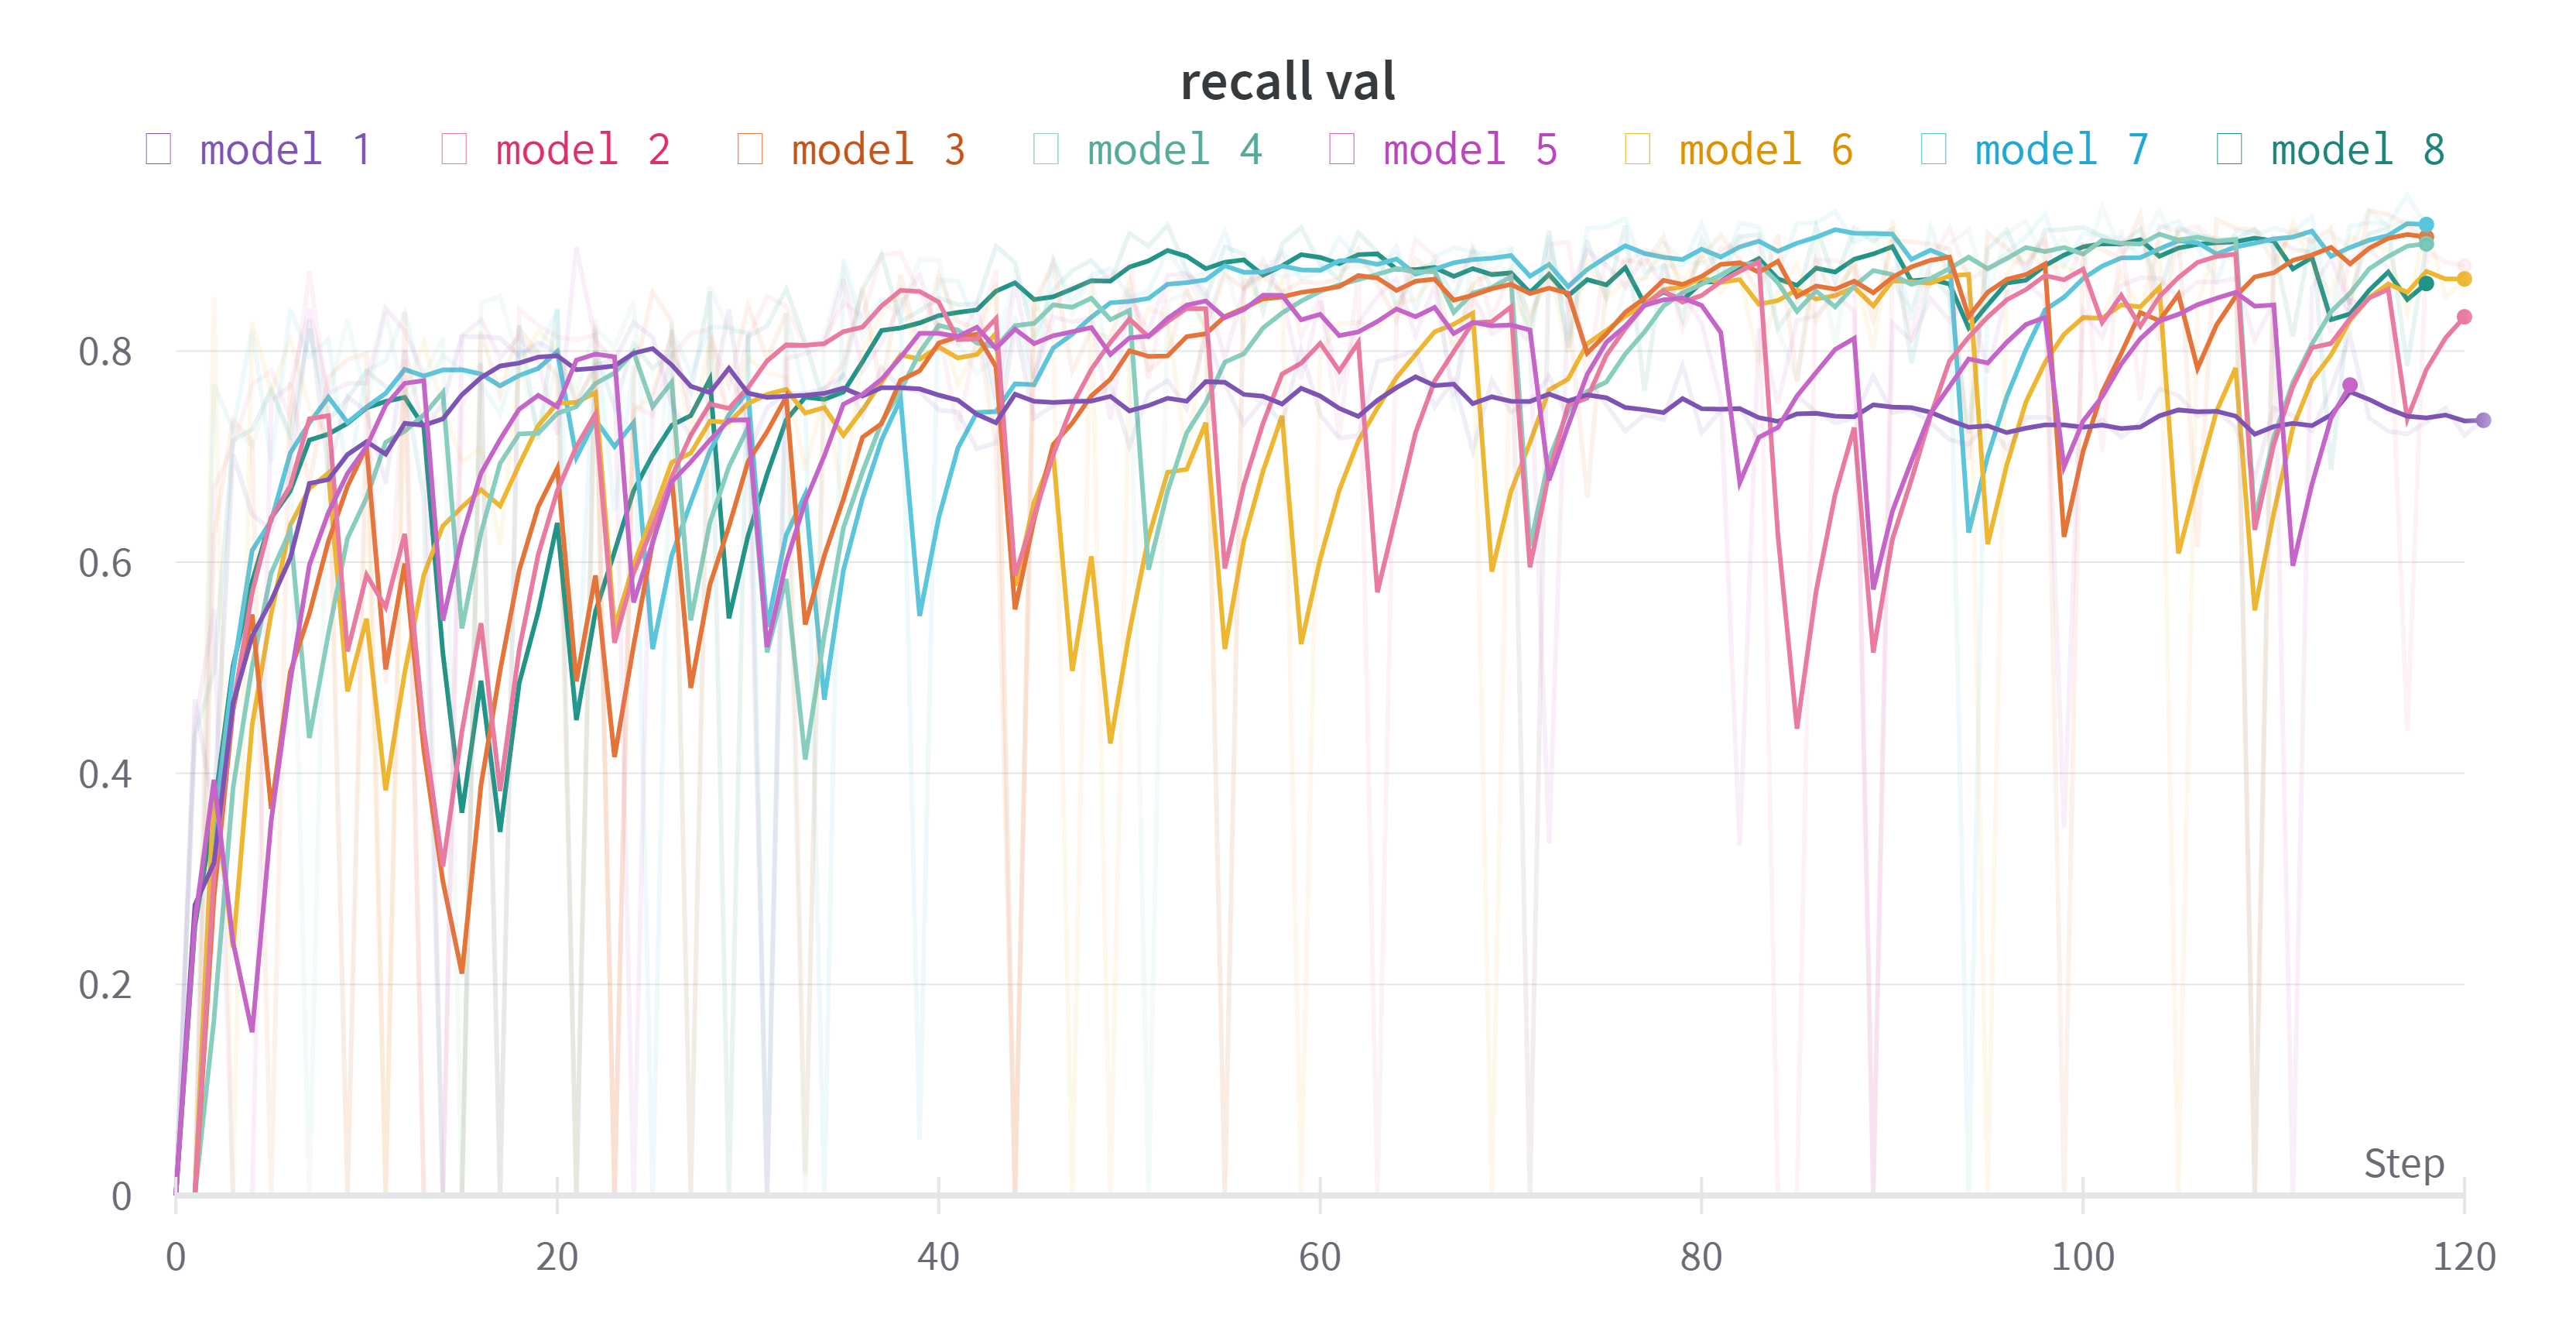

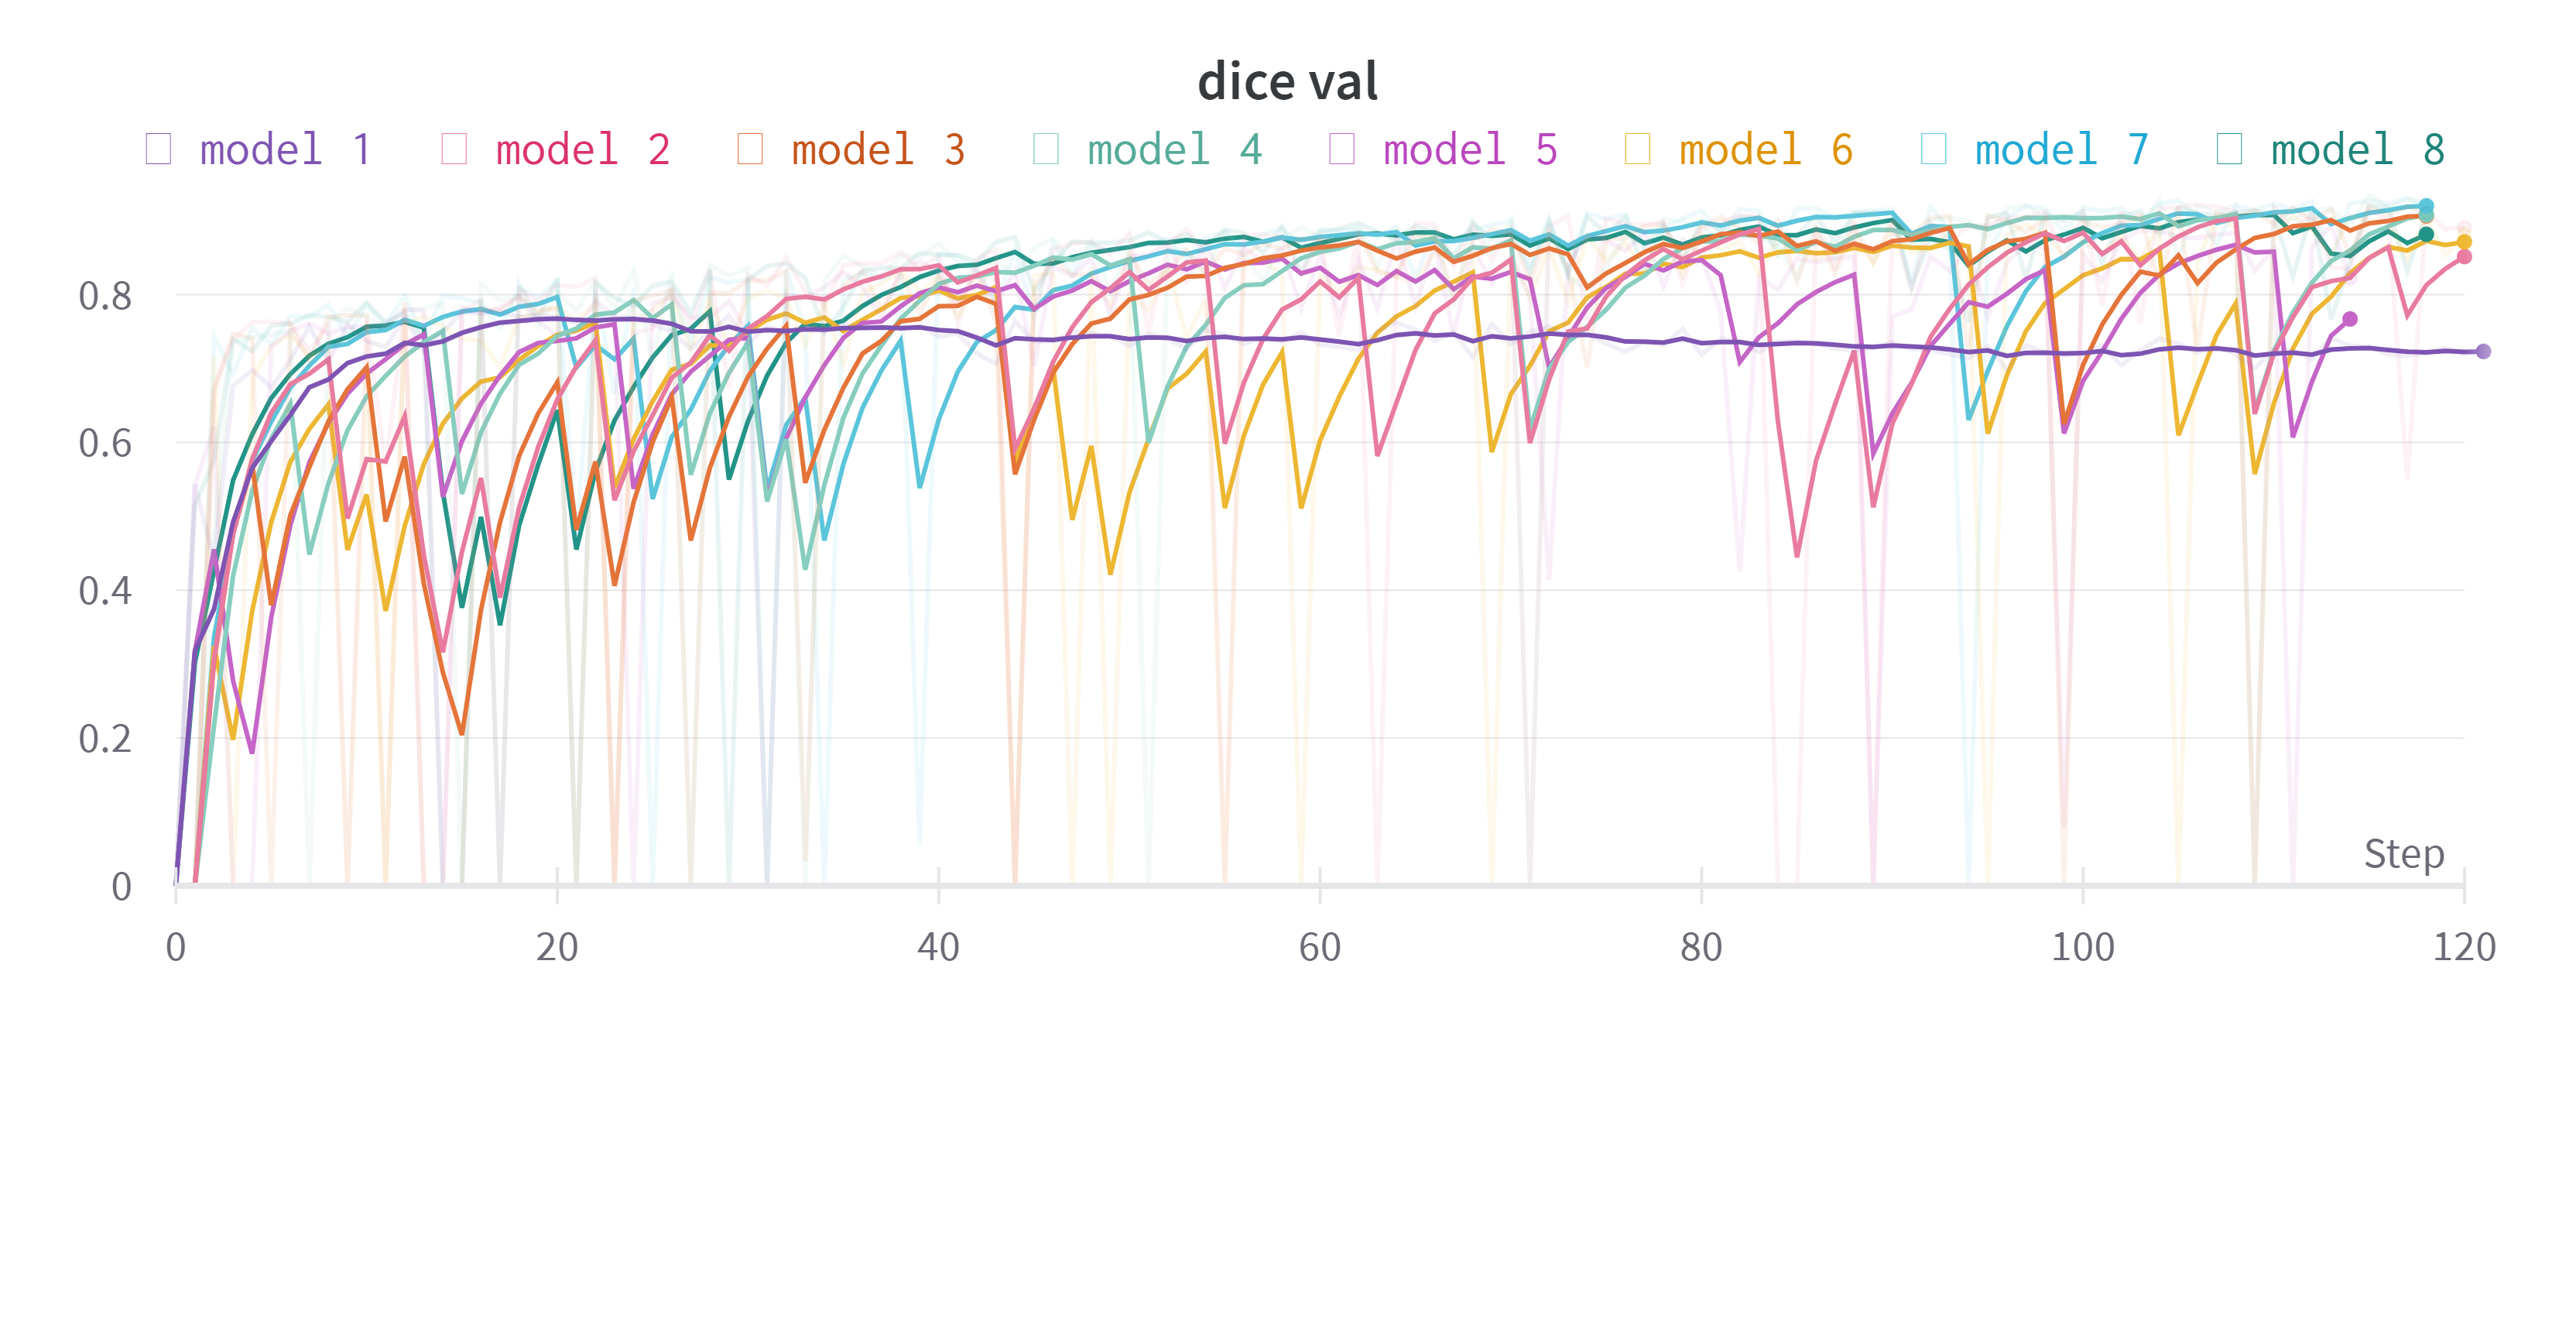

According to the recorded metrics, the best performing models compared to the reference model (Model 1) were Model 2 (K-means clustering was trained on all extracted features) with the mean DSC: 0.619, precision: 0.629 and recall: 0.959 and Model 8 (Fuzzy C-means was trained on all extracted features ) with the mean DSC:. 0.616, precision: 0.608 and recall: 0.949. The mean DSC of the Model 2 improved by 17.5%, precision was improved by 37.1% and the recall by 1.3%. In the Model 8 metrics were improved by 16..9%, 32.5% and 0.2% respectively.

**Conclusions and future work**

In the current project the undersampling clustering-based method for sequence selection was explored. It showed promising results and has a potential for further work. 
Seven features describing PET imaging were selected in order to create clusters of sequences. The dataframe containing the features was created. Two clustering algorithms were used in the study: K-means and Fuzzy C-means. The trained clustering algorithms were used to group the training and the validation data of the segmentation model in [3] into clusters. The performance of the proposed method was assessed using the segmentation model. It was trained and validated on a reference dataset first and on different sets of sequences selected with the proposed methods. The final results were finally compared and discussed.
Since the model trained on a dataset created using the Fuzzy C-means clustering showed the best results, it can be further studied. Also, training for more epochs could be tried to see if the performance of any of the created models could be improved.
